# High-fidelity prototype

# NLP portion: Part 3
To what extent do current ML studies in organ transplant research address Diversity, Equity, and Equality (DEE)?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import io
import matplotlib.pyplot as plt
from google.colab import files
import re, nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
import matplotlib.colors as mcolors
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

!pip install contractions
import contractions

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.0 MB/s eta 0:00:00


In [2]:
# Choose the dataset to upload
uploaded = files.upload()

Saving organ_papers.csv to organ_papers.csv


In [3]:
# Read the dataset into a Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['organ_papers.csv']))
df = df[['title', 'abstract', 'discussion']]

# Inspect the first five rows of the data
df.head()

,title,abstract,discussion
0,Allocating organs through algorithms and equit...,Digitization in transplantation is not a new p...,The article has shown some of the risks of unf...
1,Individualizing liver transplant immunosuppres...,"After organ transplant, patients are on a merr...",Transplant patients undergo combination therap...
2,Fairly Predicting Graft Failure in Liver Trans...,Liver transplant is an essential therapy perfo...,We conduct experiments to compare the predicti...
3,A machine learning-based approach to prognosti...,Objective\nThe prediction of survival time aft...,This study demonstrates that machine learning-...
4,Personalized Donor-Recipient Matching for Orga...,Organ transplants can improve the life expecta...,Experiments were conducted using the UNOS data...


In [ ]:
# Combining title/abstract/discussion
df['combined']=df.apply(lambda x: ' '.join(x), axis=1)

In [4]:
df.shape

(173, 3)

In [ ]:
# run if the above is already uploaded
# df = pd.read_csv('organ_papers.csv')

# Data cleaning

In [ ]:
# Let's perform some basic data cleaning tasks such as:
# - Remove URLs
# - Converting the date column to datetime
# - Lowercasing the texts
# - Removing special characters and numbers
# - Lemmatize the tokens

def remove_url(text):
    return re.sub(r'http\s+', '', text)

def remove_extra_spaces(text):
    return re.sub('\s\s+',' ',text)

# Function to remove special characters and numbers
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', ' ', text)

def remove_new_lines(text):
    return re.sub(r'\n', ' ', text)


def remove_stop_words(words):

    context_sensitive_stop_words = set(['machine', 'learning', 'machine learning', 'deep', 'deep learning',
                                        'artificial', 'intelligence', 'artificial intelligence',
                                        'organ', 'organ transplant', 'organ transplantation', 'organs',
                                        'transplant', 'transplantation','transplanted',
                                        'introduction','methods','results','discussion','limitations','conclusion'])


    # Create a set of English stop words. Sets are faster for membership tests than lists.
    stop_words_set = set(stopwords.words('english')) | context_sensitive_stop_words

    # Return a new list that contains only the tokens that are not stop words.
    # The token is also converted to lowercase to ensure case-insensitive matching.
    return [word for word in words.split() if word not in stop_words_set]

# Function to map NLTK position tags to WordNet tags
def get_wordnet_pos(word, pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def word_lemmatizer(text):
    tagged_tokens = nltk.pos_tag(text)
    return [WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word, tag)) for word, tag in tagged_tokens]

stop_words=stopwords.words('english')
stop_words.append("also")

# Apply cleaning steps to each column
for col in df.columns:

  df[col]=df[col].astype(str).apply(lambda x: contractions.fix(x))
  df[col]=df[col].str.lower()
  df[col]=df[col].apply(remove_url)
  df[col]=df[col].apply(remove_special_characters)
  df[col]=df[col].apply(remove_extra_spaces)
  df[col]=df[col].apply(remove_new_lines)
  df[f"{col}_cleaned"]=df[col].apply(remove_stop_words)
  df[f"{col}_lemmatized"]=df[f"{col}_cleaned"].apply(lambda x: word_lemmatizer(x))

df.head()

,title,abstract,discussion,combined,title_cleaned,title_lemmatized,abstract_cleaned,abstract_lemmatized,discussion_cleaned,discussion_lemmatized,combined_cleaned,combined_lemmatized
0,allocating organs through algorithms and equit...,digitization in transplantation is not a new p...,the article has shown some of the risks of unf...,allocating organs through algorithms and equit...,"[allocating, algorithms, equitable, access, eu...","[allocate, algorithm, equitable, access, europ...","[digitization, new, phenomenon, algorithms, us...","[digitization, new, phenomenon, algorithm, use...","[article, shown, risks, unfair, outcomes, desi...","[article, show, risk, unfair, outcome, design,...","[allocating, algorithms, equitable, access, eu...","[allocate, algorithm, equitable, access, europ..."
1,individualizing liver transplant immunosuppres...,after organ transplant patients are on a merry...,transplant patients undergo combination therap...,individualizing liver transplant immunosuppres...,"[individualizing, liver, immunosuppression, us...","[individualize, liver, immunosuppression, use,...","[patients, merry, go, round, medicines, proced...","[patient, merry, go, round, medicine, procedur...","[patients, undergo, combination, therapy, subs...","[patient, undergo, combination, therapy, subst...","[individualizing, liver, immunosuppression, us...","[individualize, liver, immunosuppression, use,..."
2,fairly predicting graft failure in liver trans...,liver transplant is an essential therapy perfo...,we conduct experiments to compare the predicti...,fairly predicting graft failure in liver trans...,"[fairly, predicting, graft, failure, liver, as...","[fairly, predict, graft, failure, liver, assig...","[liver, essential, therapy, performed, severe,...","[liver, essential, therapy, perform, severe, l...","[conduct, experiments, compare, prediction, fa...","[conduct, experiment, compare, prediction, fai...","[fairly, predicting, graft, failure, liver, as...","[fairly, predict, graft, failure, liver, assig..."
3,a machine learning based approach to prognosti...,objective the prediction of survival time afte...,this study demonstrates that machine learning ...,a machine learning based approach to prognosti...,"[based, approach, prognostic, analysis, thorac...","[base, approach, prognostic, analysis, thoraci...","[objective, prediction, survival, time, transp...","[objective, prediction, survival, time, transp...","[study, demonstrates, based, methodology, sele...","[study, demonstrate, base, methodology, select...","[based, approach, prognostic, analysis, thorac...","[base, approach, prognostic, analysis, thoraci..."
4,personalized donor recipient matching for orga...,organ transplants can improve the life expecta...,experiments were conducted using the unos data...,personalized donor recipient matching for orga...,"[personalized, donor, recipient, matching]","[personalize, donor, recipient, match]","[transplants, improve, life, expectancy, quali...","[transplant, improve, life, expectancy, qualit...","[experiments, conducted, using, unos, database...","[experiment, conduct, use, unos, database, pat...","[personalized, donor, recipient, matching, tra...","[personalize, donor, recipient, match, transpl..."


# Word clouds for each section

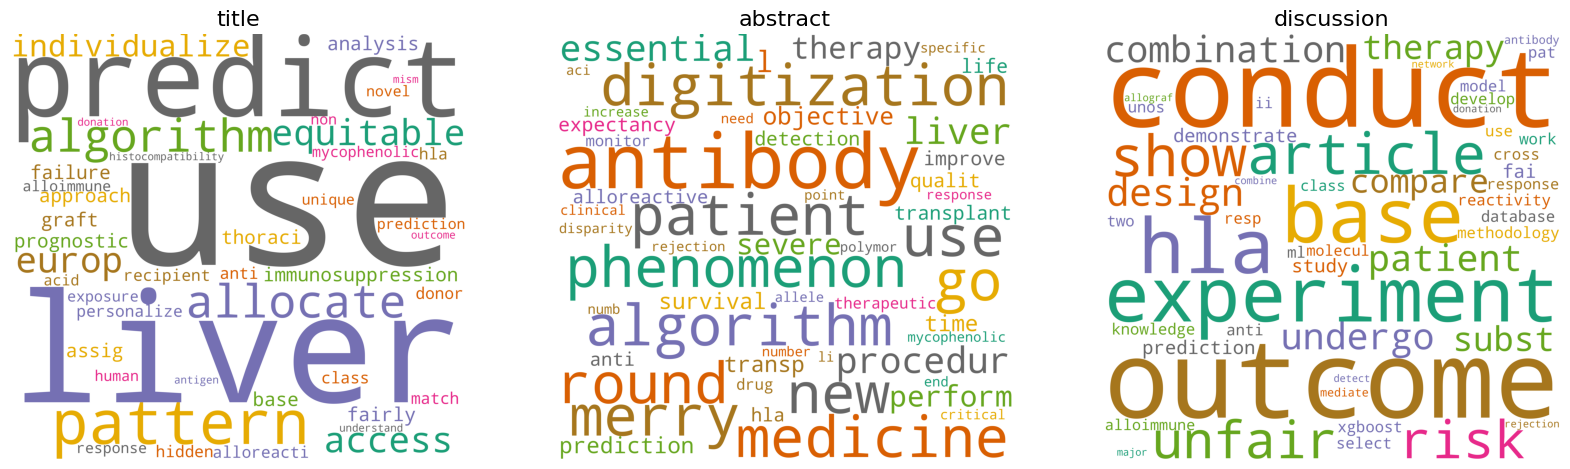

In [ ]:
list_cols = ['title_lemmatized','abstract_lemmatized','discussion_lemmatized']

cloud = WordCloud(background_color='white',
                  width=3000,
                  height=2800,
                  colormap='Dark2_r',
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    plt.gca().imshow(cloud.generate(' '.join(str(df[list_cols[i]]).split('\n')[:-1]))) #remove the name of column and dtype from str
    plt.gca().set_title(list_cols[i].split('_')[0], fontdict=dict(size=16))
    plt.gca().axis('off')

Titles

Total number of unique words

In [ ]:
tl=pd.DataFrame([item for sublist in list(df["title_lemmatized"]) for item in sublist],columns=['word'])
len(tl['word'].unique())

585

Most frequent words identified by word cloud

In [ ]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(' '.join(str(df["title_lemmatized"]).split('\n')[:-1]))
WordCloud().process_text(' '.join(str(df["title_lemmatized"]).split('\n')[:-1]))

{'allocate': 1,
 'algorithm': 1,
 'equitable': 1,
 'access': 1,
 'europ': 1,
 'individualize': 1,
 'liver': 2,
 'immunosuppression': 1,
 'use': 3,
 'fairly': 1,
 'predict': 2,
 'graft': 1,
 'failure': 1,
 'assig': 1,
 'base': 1,
 'approach': 1,
 'prognostic': 1,
 'analysis': 1,
 'thoraci': 1,
 'personalize': 1,
 'donor': 1,
 'recipient': 1,
 'match': 1,
 'hidden': 1,
 'pattern': 2,
 'anti': 1,
 'hla': 1,
 'class': 1,
 'alloreacti': 1,
 'mycophenolic': 1,
 'acid': 1,
 'exposure': 1,
 'prediction': 1,
 'unique': 1,
 'human': 1,
 'alloimmune': 1,
 'response': 1,
 'novel': 1,
 'non': 1,
 'histocompatibility': 1,
 'antigen': 1,
 'mism': 1,
 'understand': 1,
 'donation': 1,
 'outcome': 1}

In [ ]:
sum(WordCloud().process_text(' '.join(str(df["title_lemmatized"]).split('\n')[:-1])).values())

50

Abstracts

Total number of unique words

In [ ]:
al=pd.DataFrame([item for sublist in list(df["abstract_lemmatized"]) for item in sublist],columns=['word'])
len(al['word'].unique())

3187

Most frequent words identified by word cloud

In [ ]:
cloud=WordCloud(colormap="summer",width=600,height=400).generate(' '.join(str(df["abstract_lemmatized"]).split('\n')[:-1]))
WordCloud().process_text(' '.join(str(df["abstract_lemmatized"]).split('\n')[:-1]))

{'digitization': 1,
 'new': 1,
 'phenomenon': 1,
 'algorithm': 1,
 'use': 1,
 'patient': 1,
 'merry': 1,
 'go': 1,
 'round': 1,
 'medicine': 1,
 'procedur': 1,
 'liver': 1,
 'essential': 1,
 'therapy': 1,
 'perform': 1,
 'severe': 1,
 'l': 1,
 'objective': 1,
 'prediction': 1,
 'survival': 1,
 'time': 1,
 'transp': 1,
 'transplant': 1,
 'improve': 1,
 'life': 1,
 'expectancy': 1,
 'qualit': 1,
 'detection': 1,
 'alloreactive': 1,
 'anti': 1,
 'hla': 1,
 'antibody': 2,
 'therapeutic': 1,
 'drug': 1,
 'monitor': 1,
 'mycophenolic': 1,
 'aci': 1,
 'allele': 1,
 'specific': 1,
 'response': 1,
 'polymor': 1,
 'rejection': 1,
 'critical': 1,
 'clinical': 1,
 'end': 1,
 'point': 1,
 'li': 1,
 'increase': 1,
 'disparity': 1,
 'number': 1,
 'need': 1,
 'numb': 1}

In [ ]:
sum(WordCloud().process_text(' '.join(str(df["abstract_lemmatized"]).split('\n')[:-1])).values())

53

Discussion

Total number of unique words

In [ ]:
dl=pd.DataFrame([item for sublist in list(df["discussion_lemmatized"]) for item in sublist],columns=['word'])
len(dl['word'].unique())

6490

Most frequent words identified by word cloud

In [ ]:
cloud=WordCloud(colormap="spring",width=600,height=400).generate(' '.join(str(df["discussion_lemmatized"]).split('\n')[:-1]))
WordCloud().process_text(' '.join(str(df["discussion_lemmatized"]).split('\n')[:-1]))

{'article': 1,
 'show': 1,
 'risk': 1,
 'unfair': 1,
 'outcome': 2,
 'design': 1,
 'patient': 1,
 'undergo': 1,
 'combination': 1,
 'therapy': 1,
 'subst': 1,
 'conduct': 2,
 'experiment': 2,
 'compare': 1,
 'prediction': 1,
 'fai': 1,
 'study': 1,
 'demonstrate': 1,
 'base': 2,
 'methodology': 1,
 'select': 1,
 'use': 1,
 'unos': 1,
 'database': 1,
 'pat': 1,
 'knowledge': 1,
 'cross': 1,
 'reactivity': 1,
 'anti': 1,
 'hla': 2,
 'resp': 1,
 'work': 1,
 'develop': 1,
 'xgboost': 1,
 'ml': 1,
 'model': 1,
 'two': 1,
 'alloimmune': 1,
 'response': 1,
 'class': 1,
 'ii': 1,
 'molecul': 1,
 'antibody': 1,
 'mediate': 1,
 'rejection': 1,
 'major': 1,
 'allograf': 1,
 'detect': 1,
 'donation': 1,
 'combine': 1,
 'network': 1}

In [ ]:
sum(WordCloud().process_text(' '.join(str(df["discussion_lemmatized"]).split('\n')[:-1])).values())

56

Overall distribution of words (titles/abstracts/discussions combined)

In [ ]:
overall=pd.DataFrame([item for sublist in list(df["combined_lemmatized"]) for item in sublist],columns=['word'])
len(overall['word'].unique())

6952

In [ ]:
sum(WordCloud().process_text(' '.join(str(df["combined_lemmatized"]).split('\n')[:-1])).values())

51

# Build word2vec model and clustering (for all sections combined)

In [ ]:
model = Word2Vec(df["combined_lemmatized"],
                     min_count=1,
                     window=10)

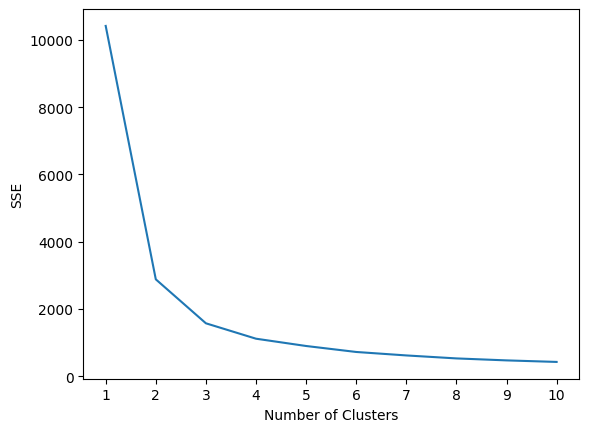

In [ ]:
#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(model.wv.vectors)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3).fit(model.wv.vectors)
labels = kmeans.labels_
vocab = list(model.wv.key_to_index)
clusters = [list(a) for a in zip(vocab, labels)]

df_new=pd.concat([pd.DataFrame(model.wv.vectors),pd.DataFrame(vocab,columns=['word']),
           pd.DataFrame(labels,columns=['labels'])],axis=1)

df_new.head() # word2vec df

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,word,labels
0,-1.474326,0.527806,0.373079,0.139446,-0.270214,-0.868098,-0.616873,1.397994,-0.133221,-0.601827,...,0.317366,0.428415,1.304589,0.898736,-0.182622,-0.631198,-0.632608,-0.083299,model,1
1,-1.438045,0.561149,0.296959,0.093404,-0.429074,-0.861235,-0.394131,1.303130,-0.151345,-0.576703,...,0.255355,0.341052,1.093759,0.823170,0.000506,-0.707765,-0.372121,-0.255543,use,1
2,-0.599674,0.490491,0.108122,0.363293,-0.749422,-0.790463,0.667100,1.117594,0.094117,-0.541574,...,0.109485,0.243990,0.619643,0.667156,0.253497,-1.312923,0.788354,-0.500930,patient,1
3,-1.238606,0.622534,0.176810,0.137302,-0.548577,-0.842313,0.094631,1.290693,-0.055321,-0.509789,...,0.170057,0.239566,0.867702,0.773516,0.138738,-0.909413,0.124543,-0.376800,study,1
4,-2.002215,0.741824,0.185307,-0.035256,-0.484722,-0.835870,-0.402991,1.532272,-0.211652,-0.325281,...,0.198436,0.110805,0.981213,0.903208,0.188956,-0.493097,-0.329850,-0.402195,data,1


In [ ]:
df_new[df_new['labels']==0].shape

(965, 104)

In [ ]:
df_new[df_new['labels']==1].shape

(460, 104)

In [ ]:
df_new[df_new['labels']==2].shape

(5527, 104)

In [ ]:
df_new[df_new['word']=='ageism']

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,word,labels,tsne-2d-one,tsne-2d-two
2498,-0.117765,0.063543,0.017733,0.020037,-0.080285,-0.10283,0.017265,0.141591,-0.003898,-0.048219,...,0.085615,0.091743,0.028495,-0.109852,0.038929,-0.04072,ageism,2,37.603447,-127.972755


Visualize clusters of word embeddings

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 6952 samples in 0.001s...
[t-SNE] Computed neighbors for 6952 samples in 2.456s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6952
[t-SNE] Computed conditional probabilities for sample 2000 / 6952
[t-SNE] Computed conditional probabilities for sample 3000 / 6952
[t-SNE] Computed conditional probabilities for sample 4000 / 6952
[t-SNE] Computed conditional probabilities for sample 5000 / 6952
[t-SNE] Computed conditional probabilities for sample 6000 / 6952
[t-SNE] Computed conditional probabilities for sample 6952 / 6952
[t-SNE] Mean sigma: 0.016639
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.646133
[t-SNE] KL divergence after 3000 iterations: 1.976287


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

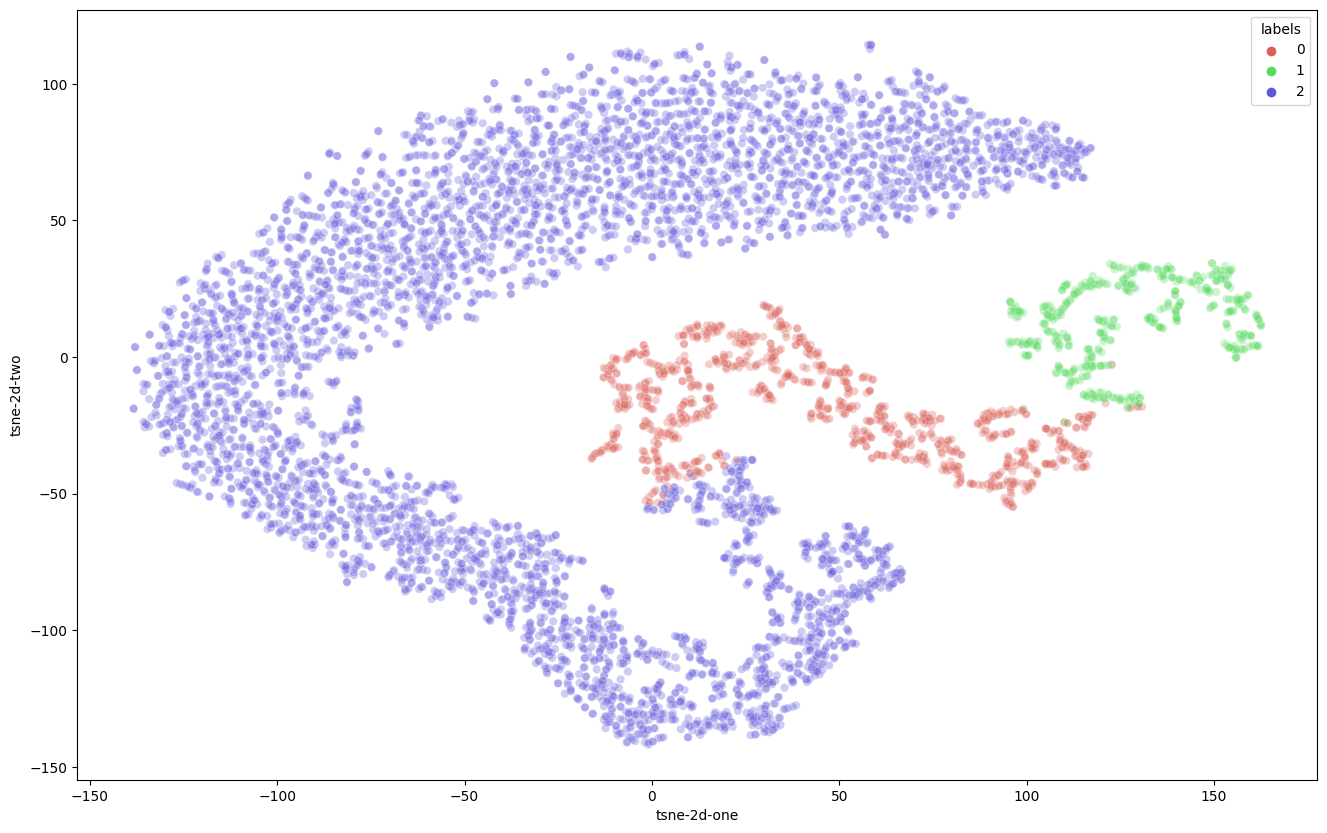

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=3000,init='pca',random_state=42)
tsne_results = tsne.fit_transform(model.wv.vectors)

df_new['tsne-2d-one'] = tsne_results[:,0]
df_new['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue = 'labels',
    palette=sns.color_palette("hls", len(df_new['labels'].unique())),
    data=df_new,
    legend="full",
    alpha=0.3
)

# Create word clouds of clusters

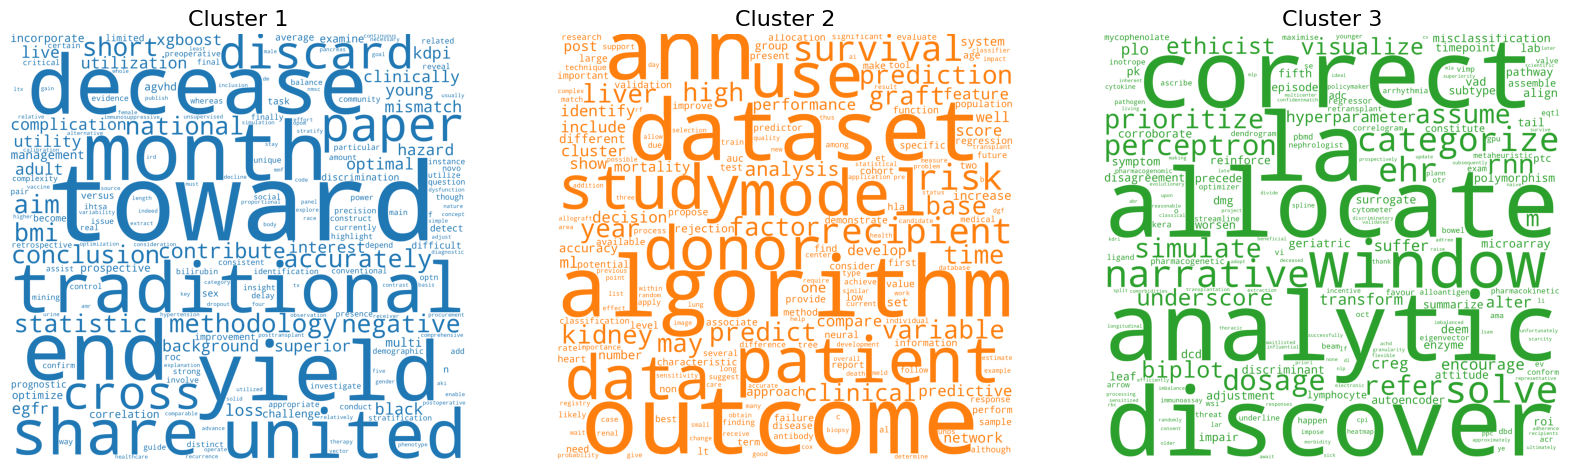

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=3000,
                  height=2800,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)

    plt.gca().imshow(cloud.generate(' '.join(df_new[df_new['labels']==i]['word'])))
    plt.gca().set_title('Cluster ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

In [ ]:
WordCloud().process_text(' '.join(str(df["combined_lemmatized"]).split('\n')[:-1]))

{'allocate': 1,
 'algorithms': 1,
 'equitable': 1,
 'access': 1,
 'euro': 1,
 'individualize': 1,
 'liver': 2,
 'immunosuppression': 1,
 'use': 3,
 'fairly': 1,
 'predict': 2,
 'graft': 1,
 'failure': 1,
 'assig': 1,
 'base': 1,
 'approach': 1,
 'prognostic': 1,
 'analysis': 1,
 'thoraci': 1,
 'personalize': 1,
 'donor': 1,
 'recipient': 1,
 'match': 1,
 'transpl': 1,
 'hide': 1,
 'pattern': 2,
 'anti': 1,
 'hla': 1,
 'class': 1,
 'alloreactivi': 1,
 'mycophenolic': 1,
 'acid': 1,
 'exposure': 1,
 'prediction': 1,
 'unique': 1,
 'human': 1,
 'alloimmune': 1,
 'responses': 1,
 'novel': 1,
 'non': 1,
 'histocompatibility': 1,
 'antigen': 1,
 'mism': 1,
 'understand': 1,
 'donation': 1,
 'outcomes': 1}